### iris Pytorch 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Define the model 
import torch
import torch.nn as nn
import torch.utils.data as utils
import torch.utils.data as td
import torch.nn.functional as F
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
iris = datasets.load_iris()

In [3]:
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.40, random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of features and labels:")
print('(features: ',iris.feature_names, ')')


Training Set: 90, Test Set: 60 

Sample of features and labels:
(features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] )


In [4]:
# Take a look at the first 25 training features and corresponding labels
for n in range(0,24):
    print(x_train[n], y_train[n], '(' + iris.target_names[y_train[n]] + ')')

[6.  3.4 4.5 1.6] 1 (versicolor)
[4.8 3.1 1.6 0.2] 0 (setosa)
[5.8 2.7 5.1 1.9] 2 (virginica)
[5.6 2.7 4.2 1.3] 1 (versicolor)
[5.6 2.9 3.6 1.3] 1 (versicolor)
[5.5 2.5 4.  1.3] 1 (versicolor)
[6.1 3.  4.6 1.4] 1 (versicolor)
[7.2 3.2 6.  1.8] 2 (virginica)
[5.3 3.7 1.5 0.2] 0 (setosa)
[4.3 3.  1.1 0.1] 0 (setosa)
[6.4 2.7 5.3 1.9] 2 (virginica)
[5.7 3.  4.2 1.2] 1 (versicolor)
[5.4 3.4 1.7 0.2] 0 (setosa)
[5.7 4.4 1.5 0.4] 0 (setosa)
[6.9 3.1 4.9 1.5] 1 (versicolor)
[4.6 3.1 1.5 0.2] 0 (setosa)
[5.9 3.  5.1 1.8] 2 (virginica)
[5.1 2.5 3.  1.1] 1 (versicolor)
[4.6 3.4 1.4 0.3] 0 (setosa)
[6.2 2.2 4.5 1.5] 1 (versicolor)
[7.2 3.6 6.1 2.5] 2 (virginica)
[5.7 2.9 4.2 1.3] 1 (versicolor)
[4.8 3.  1.4 0.1] 0 (setosa)
[7.1 3.  5.9 2.1] 2 (virginica)


In [5]:
print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.3.0


In [6]:
torch.cuda.get_device_name(0)

'P102-100'

### Prepare the Data for Pytorch
PyTorch makes use of _data loaders_ to load training and validation data in batches. We've already loaded the data into NumPy arrays, but we need to wrap those in PyTorch datasets (in which the data is converted to PyTorch tensor objects) and create loaders to read batches from those datasets.

In [7]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = utils.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=10,
    shuffle=False, num_workers=1)

In [8]:
# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = utils.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=10,
    shuffle=False, num_workers=1)


In [9]:
print("Loaders ready")

Loaders ready


### Define a Neural Network
Now we're ready to define our neural network. In this case, we'll create a network that consists of 3 fully-connected layers:

- An input layer that receives four input values (the iris features) and applies a ReLU activation function.
- A hidden layer that receives ten inputs and applies a ReLU activation function.
- An output layer that uses a SoftMax activation function to generate three outputs (which represent the probabilities for the three iris species)                                

In [10]:
# Number of hidden layer nodes
hl = 10

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print("Executing the model on :",device)

# Define the neural network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x),dim=1)
        return x

Executing the model on : cuda:0


In [12]:
# Create a model instance from the network
model = IrisNet()
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


### Train the Model¶
To train the model, we need to repeatedly feed the training values forward through the network, use a loss function to calculate the loss, use an optimizer to backpropagate the weight and bias value adjustments, and validate the model using the test data we withheld.

To do this, we'll create a function to train and optimize the model, and function to test the model. Then we'll call these functions iteratively over 100 epochs, logging the loss and accuracy statistics for each epoch.

In [13]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return loss
    avg_loss = train_loss / len(data_loader.dataset)
    return avg_loss

In [14]:
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch, tensor in enumerate(data_loader):
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # return validation loss and prediction accuracy for the epoch
    avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = test_loss / len(data_loader.dataset)
    return avg_loss, avg_accuracy
 


In [15]:
# Specify the loss criteria (CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()



In [16]:
# Specify the optimizer (we'll use a Stochastic Gradient Descent optimizer)
learning_rate = 0.01
learning_momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_momentum)

In [17]:
# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []


In [18]:
# Train over 100 epochs
epochs = 100
for epoch in range(1, epochs + 1):
    
    # Feed the training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss, accuracy = test(model, test_loader)
    
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    
    # Print stats for every 10th epoch so we can see training progress
    if (epoch) % 10 == 0:
        print('Epoch {:d}: Training loss= {:.4f}, Validation loss= {:.4f}, Accuracy={:.4%}'.format(epoch, train_loss, test_loss, accuracy))

Epoch 10: Training loss= 0.0880, Validation loss= 0.0916, Accuracy=61.6667%
Epoch 20: Training loss= 0.0738, Validation loss= 0.0774, Accuracy=85.0000%
Epoch 30: Training loss= 0.0657, Validation loss= 0.0666, Accuracy=93.3333%
Epoch 40: Training loss= 0.0621, Validation loss= 0.0628, Accuracy=95.0000%
Epoch 50: Training loss= 0.0604, Validation loss= 0.0611, Accuracy=96.6667%
Epoch 60: Training loss= 0.0595, Validation loss= 0.0603, Accuracy=96.6667%
Epoch 70: Training loss= 0.0591, Validation loss= 0.0599, Accuracy=96.6667%
Epoch 80: Training loss= 0.0589, Validation loss= 0.0603, Accuracy=95.0000%
Epoch 90: Training loss= 0.0581, Validation loss= 0.0596, Accuracy=98.3333%
Epoch 100: Training loss= 0.0581, Validation loss= 0.0593, Accuracy=96.6667%


### Review Training and Validation Loss¶
After training is complete, we can examine the loss metrics we recorded while training and validating the model. We're really looking for two things:

The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
The training loss and validations loss should follow a similar trend, showing that the model is not overfitting to the training data.
Let's plot the loss metrics and see:

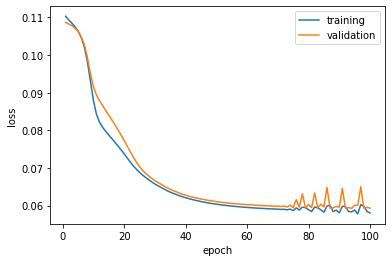

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### View the Learned Weights and Biases¶
The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:

* Layer 1: There are four input values going to ten output nodes, so there should be 10 x 4 weights and 10 bias values.
* Layer 2: There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
* Layer 3: There are ten input values going to three output nodes, so there should be 3 x 10 weights and 3 bias values.

In [20]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[ 0.7827688   0.01950931  0.3165727  -0.54405993]
 [ 0.03756158 -0.2736474   0.18251368  0.13078955]
 [-0.05947161 -0.27236345  0.7997254   0.30942726]
 [-0.0642789  -0.2883746   0.03579289  0.01822281]
 [ 0.46551785  0.42747468 -0.34914517 -0.42913535]
 [ 0.9307589   0.6958349  -1.1582279  -0.44750574]
 [-0.41675967  0.3788507  -0.3649776   0.3523246 ]
 [ 0.36351356 -0.24413237  0.21752827  0.35570437]
 [-0.19753523 -0.11047829  0.3792388  -0.37689948]
 [-0.61159843 -0.07407307  1.4278404   1.2208402 ]]
fc1.bias 
 [ 0.3985393  -0.36301732 -0.26634976 -0.05941463  0.6902861   0.51783395
  0.08423001 -0.40198988  0.09209709 -0.7269945 ]
fc2.weight 
 [[-0.37557986  0.2933699   0.21297328 -0.08303306  0.22826883  0.19344842
   0.29180083 -0.03570412 -0.28917363  0.00954436]
 [ 0.76548976 -0.21883103 -0.45206395 -0.30774105  0.7888815   1.1633899
   0.00753829  0.04436429  0.21818103 -1.231047  ]
 [ 0.3128067   0.21057963  0.28520533  0.05154461 -0.19590734 -0.2658019
   0.22

### Evaluate Model Performance¶
So, is the model any good? The raw accuracy reported from the validation data would seem to indicate that it predicts pretty well; but it's typically useful to dig a little deeper and compare the predictions for each possible class. A common way to visualize the performace of a classification model is to create a confusion matrix that shows a crosstab of correct and incorrect predictions for each class.

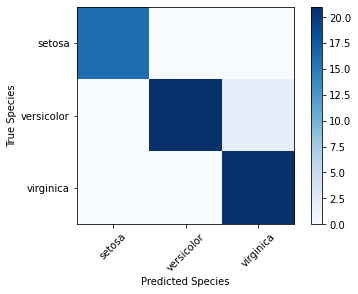

In [21]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(x_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(iris.target_names))
plt.xticks(tick_marks, iris.target_names, rotation=45)
plt.yticks(tick_marks, iris.target_names)
plt.xlabel("Predicted Species")
plt.ylabel("True Species")
plt.show()